### In the third lesson we will implement the Cherenkov photons produced by the charged particles crossing the water tank 
To start, we need to compute the Cherenkov threshold for the particle.   
In this notebook, we focus on electrons   

In [1]:
# First of all execute python script to load the defined functions 

%run functions.py 

In [2]:
import numpy as np  
from astropy import units as u
import matplotlib.pyplot as plt

# Define muon energy 

ek = 1000 * u.MeV
beta = _beta(ek,me)

In [3]:
# 
n = 1.333

def check_Ch_th(beta,n): 
    return beta > 1 / n 

In [4]:
# Compute Cherenkov threshold in kinetic energy for a muon in water 
b_th = 1. / n
gamma_th = 1 / np.sqrt( 1 - b_th*b_th)
e_th = (gamma_th -1)* me
print('Cherenkov kinetic energy threshold for muon in water is: ',e_th)  

Cherenkov kinetic energy threshold for muon in water is:  0.2618073805612842 MeV


In [5]:
n_lam_bins = 61 

def cherenkov_photons_array(beta,dx):
    lambda_points = np.linspace(200,800,n_lam_bins) * u.nm 
    lambda_low = lambda_points[:-1] 
    lambda_hi = lambda_points[1:] 
    lambda_centers = (lambda_low + lambda_hi) / 2

    return [lambda_low,lambda_hi], 2.*np.pi * alpha * (1. / lambda_low - 1. / lambda_hi) * ( 1. - 1. / (beta**2 * n**2 )) * dx.to(u.nm)



In [6]:
# Now let's go back to the 1 GeV muon, compute the Cherenkov photons produced along it's track 

ek_e = 1 * u.GeV 
beta_e = _beta(ek_e,me)
gamma_e = _gamma(ek_e,me)   
Wmax_e = _Wmax(ek_e,me)

# Retrieve water properties 

Z_A=0.55509 *u.mol / u.g #mol g^-1, atomic number Z over atomic mass mol g^-1 
rho=1 * u.g / u.cm**3 #g cm^-3, density of liquid water 
I=7.97e-5 * u.MeV #MeV, mean excitation energy

K=0.307075 * u.MeV * u.cm **2 / u.mol #MeV mol^−1 cm2
X0 = 36.08 * u.cm 

In [7]:
h = 120 * u.cm  # Height of the tank 
dx = 1 * u.cm 
nsteps = int(h/dx)
d = 0. * u.cm

d_array = np.zeros(nsteps) * u.cm
ch_photons = np.zeros(nsteps, dtype=object)
tot_ch_photons = np.zeros(nsteps)
z_photons = np.zeros((nsteps,n_lam_bins), dtype=object) 
z_photons_list = []
z_photons_list_lambda = []
z_photons_list_lambda_2_3 = []
z_photons_list_lambda_3_4 = []
z_photons_list_lambda_4_5 = []
z_photons_list_lambda_5_6 = []
z_photons_list_lambda_6_7 = []
z_photons_list_lambda_7_8 = []
z_photon_list_array = [z_photons_list_lambda_2_3, z_photons_list_lambda_3_4, z_photons_list_lambda_4_5, z_photons_list_lambda_5_6, z_photons_list_lambda_6_7, z_photons_list_lambda_7_8]
lambda_edges = [200, 300, 400, 500, 600, 700, 800] * u.nm

for i_step in range(nsteps): 
    
    eloss = de_dx_elec_tot(ek_e,K, Z_A, I, rho, X0 ) * dx/2
    ek_e = ek_e - eloss 
    beta_e = _beta(ek_e,me)    
    
    lam_array, n_ch_mean = cherenkov_photons_array(beta_e,dx) 
    n_ch = np.random.poisson(n_ch_mean)

    for i_lam in range(len(n_ch)): 
        z_ch = np.random.uniform(d.value,(d+dx).value,size=n_ch[i_lam]) 
        z_photons[i_step][i_lam] = z_ch
        z_photons_list.extend(z_ch)
        for i_edge in range(len(lambda_edges)-1):
            if(lam_array[0][i_lam] < lambda_edges[i_edge+1] and lam_array[0][i_lam] >= lambda_edges[i_edge]):z_photon_list_array[i_edge].extend(z_ch)
        
    eloss = de_dx_elec_tot(ek_e,K, Z_A, I, rho, X0 ) * dx/2
    ek_e = ek_e - eloss 
    beta_e = _beta(ek_e,me)    
    d += dx

    d_array[i_step] = d
    ch_photons[i_step] = n_ch 
    tot_ch_photons[i_step] = np.sum(n_ch)
    
    print(ek_e)
    
    if(beta_e < 1/n or ek_e < 0.1 * u.MeV):break  


/home/workspace/.local/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, '# Cherenkov photons')

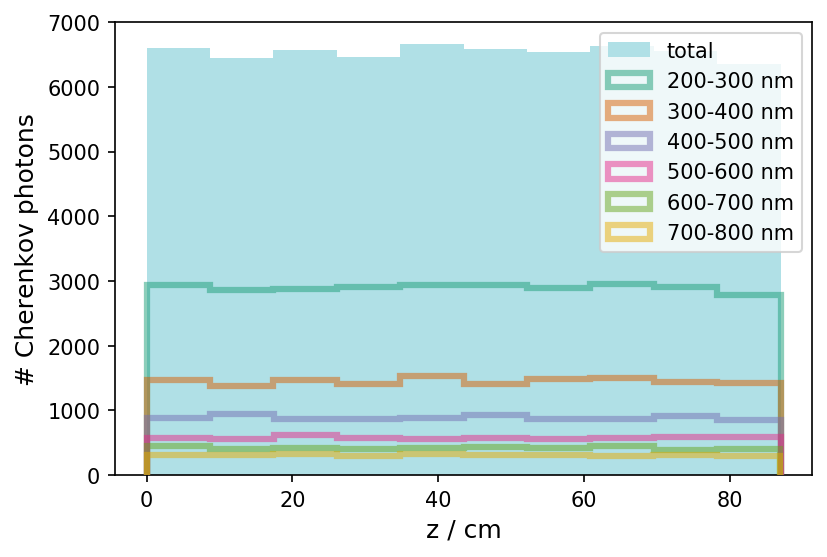

In [8]:
plt.figure(dpi=150)
cols = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']

plt.hist(z_photons_list, label='total', color='powderblue')

for i in range(len(z_photon_list_array)):
    label_string = ('%d-%d nm'%(lambda_edges[i].value,lambda_edges[i+1].value) )
    plt.hist(z_photon_list_array[i],alpha=0.5,label=label_string, color=cols[i+1], linewidth=3, edgecolor=cols[i], fill=False, histtype='step',zorder=3 )
    
plt.legend()
plt.xlabel('z / cm',size=12)
plt.ylabel('# Cherenkov photons',size=12)

Text(0, 0.5, '# Cherenkov photons')

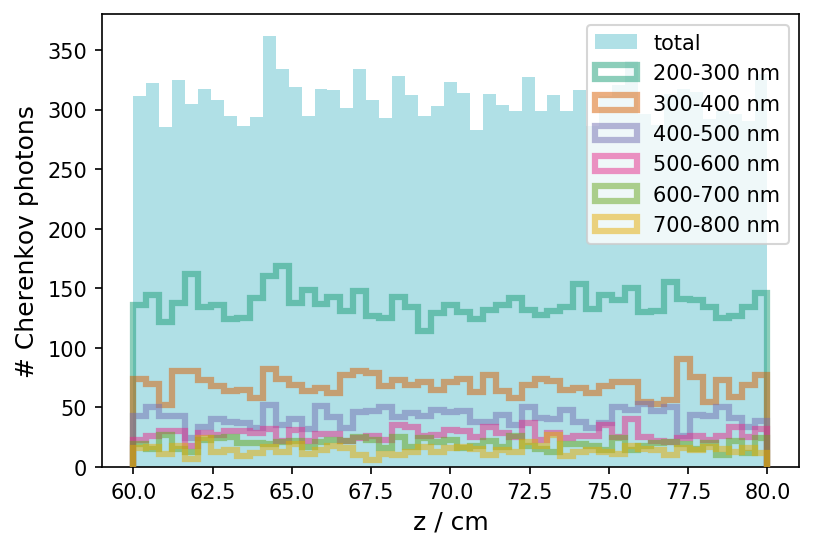

In [9]:
plt.figure(dpi=150)
cols = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']

plt.hist(z_photons_list, bins=np.linspace(60,80,50),label='total', color='powderblue')

for i in range(len(z_photon_list_array)):
    label_string = ('%d-%d nm'%(lambda_edges[i].value,lambda_edges[i+1].value) )
    plt.hist(z_photon_list_array[i],bins=np.linspace(60,80,50), alpha=0.5,label=label_string, color=cols[i+1], linewidth=3, edgecolor=cols[i], fill=False, histtype='step',zorder=3 )
    
plt.legend()
plt.xlabel('z / cm',size=12)
plt.ylabel('# Cherenkov photons',size=12)